## Great Barrier Reef - Training Script

Downloads the specified branch of the repo from the github and can run the training or even a full parameter sweep.

In [1]:
#@title Select your options
mode = "train"    #@param ["train", "evaluate"]
branch_name = "GBR_starfish_detection"    #@param {type:"string"}
wandb_model = "stuttgartteam8/protect_gbr/15ysbcdo"    #@param ["New", "stuttgartteam8/protect_gbr/15ysbcdo", "stuttgartteam8/protect_gbr/225emsat", "stuttgartteam8/protect_gbr/2h1ckitl", "stuttgartteam8/protect_gbr/29mmyvgw", "stuttgartteam8/protect_gbr/2pjrq56n"]
dataset = "full_reduced_size"    #@param ["full", "full_reduced_size", "partial"]

In [2]:
!nvidia-smi

Wed Jan 19 21:49:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# download dataset
%cd /content/
if dataset == "full":
    !gdown https://drive.google.com/uc?id=1DW2CJja9n8d0Bub-jmJZvnKXAHrpYLkv
elif dataset == "full_reduced_size":
    !gdown https://drive.google.com/uc?id=1pJM8yoVMKrptXCZcLT26J5R7MFLHIzo9
elif dataset == "partial":
    # images 0-478 (part of whole data set)
    !gdown https://drive.google.com/uc?id=1nVROGC31eVwThW7xYUM8zuxlmQVgC9xr


/content
Downloading...
From: https://drive.google.com/uc?id=1pJM8yoVMKrptXCZcLT26J5R7MFLHIzo9
To: /content/GBR_dataset.zip
100% 3.20G/3.20G [00:21<00:00, 148MB/s]


In [4]:
%%capture
# unpack dataset
if dataset == "full" or dataset == "full_reduced_size":
    !rm -r /content/GBR_dataset
    !unzip -u "/content/GBR_dataset.zip" -d "/content/";
else:
    !unzip -u "/content/GBR_dataset_partial.zip" -d "/content/";

In [3]:
# delete existing repo to ensure the newest is fetched from github 
% cd /
!rm -r /content/dl-lab-21w-team08

# download repo
# %%capture
%cd /content/
git_access_token = "28fdd19659f4a0e5bcaf16dd820e5c68bed91102"

# !git clone https://28fdd19659f4a0e5bcaf16dd820e5c68bed91102@github.tik.uni-stuttgart.de/iss/dl-lab-21w-team08.git
clone_comand = f"git clone --single-branch --branch {branch_name} https://{git_access_token}@github.tik.uni-stuttgart.de/iss/dl-lab-21w-team08.git"
!$clone_comand

/
rm: cannot remove '/content/dl-lab-21w-team08': No such file or directory
/content
Cloning into 'dl-lab-21w-team08'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 439 (delta 4), reused 7 (delta 3), pack-reused 425
Receiving objects: 100% (439/439), 9.55 MiB | 6.80 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [6]:
# install dependencies
%%capture
!pip install wandb
!pip install tensorflow_addons
#!pip install gin-config

In [7]:
%%capture out
# run training script
# 37262d20054e8dbf092705158103cd02e31691d6
%cd /content/
!mkdir wandb
%cd /content/dl-lab-21w-team08/GBR_starfish_detection/

!wandb login 37262d20054e8dbf092705158103cd02e31691d6

In [33]:
# training

if mode == "train":
    # pass dataset path and the wandb model which is used as starting point for training
    if dataset == "full" or dataset == "full_reduced_size":
        !python main.py -p="/content/GBR_dataset/" --wandb_model={wandb_model} --dataset_slice_end=23500
    else:
        # use only 200 images for training
        !python main.py -p="/content/GBR_dataset_partial/" --wandb_model={wandb_model} --dataset_slice_end=300

wandb: Currently logged in as: davidu (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.9
wandb: Syncing run confused-grass-90
wandb: ⭐️ View project at https://wandb.ai/stuttgartteam8/protect_gbr
wandb: 🚀 View run at https://wandb.ai/stuttgartteam8/protect_gbr/runs/15ysbcdo
wandb: Run data is saved locally in /content/dl-lab-21w-team08/GBR_starfish_detection/wandb/run-20220119_162225-15ysbcdo
wandb: Run `wandb offline` to turn off syncing.

   video_id  ...  annotations
0         0  ...           []
1         0  ...           []
2         0  ...           []
3         0  ...           []
4         0  ...           []

[5 rows x 6 columns]
Loading 23500 images.
2022-01-19 16:22:32.690531: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Continue model training from wandb
Download model:
Load model:
Model: "

In [34]:
# model evaluation

%cd /content/dl-lab-21w-team08/GBR_starfish_detection/
import wandb
import tensorflow as tf
from input import load, annotate_image

wandb.init(project="protect_gbr", entity="stuttgartteam8", mode="disabled") 
if dataset == "full" or dataset == "full_reduced_size":
    arg_update = {"data_dir": "/content/GBR_dataset/"}
else:
    arg_update = {"data_dir": "/content/GBR_dataset_partial/"}
wandb.config.update(arg_update, allow_val_change=True)
config = wandb.config

ds_train, ds_val, ds_test = load(config)

if mode == "evaluate":
    # download the model from wandb
    print("Downloading model")
    api = wandb.Api()
    run = api.run(wandb_model)
    run.file("model.h5").download(replace=True)

    print("Loading model")
    model = tf.keras.models.load_model('model.h5', compile=False) 
    print(model.summary())

else:
    # use the model from this training session and evaluate it

    file = "/content/dl-lab-21w-team08/GBR_starfish_detection/wandb/latest-run/files/model.h5"
    model = tf.keras.models.load_model(file, compile=False) # todo: the path for the model needs to be adapted!

/content/dl-lab-21w-team08/GBR_starfish_detection
   video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []
Loading 300 images.


Ground Truth


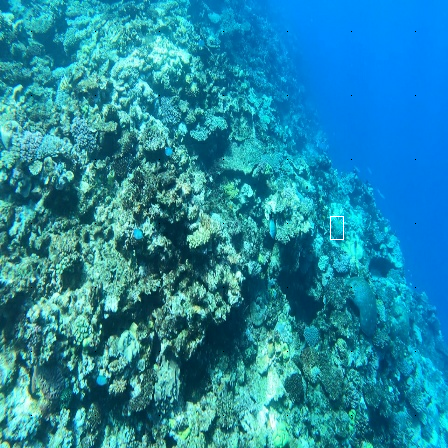

Prediction


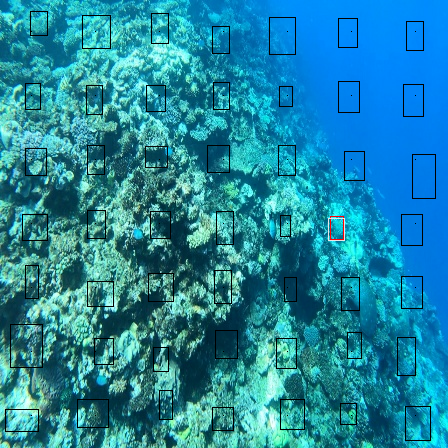

In [35]:

import tensorflow.keras as keras
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np

for x,y in ds_test:
    i = np.random.randint(0, config.batch_size)
    print("Ground Truth")
    img = annotate_image(config, x[i], y[i], y[i])
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2_imshow(img)
    print("Prediction")
    y_pred = model.predict(x)
    img = annotate_image(config, x[i], y_pred[i], y[i])
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2_imshow(img)
    break
    